<h2></h2>
<p></p>
<h1>Analysing BCI data</h1>
<p>
This tutorial will give some explanations of BCI data analysis. We will do it with using python mne library, but in other languages and libraries should me analogs. Some actual code you can find <a href="https://github.com/VitalyVV/meditation_project/blob/master/Untitled.ipynb">here</a>.
</p>
<h2>Why we need to analyse BCI data?</h2>
<p>The success of the experiment lies not only in the correct formulation of the experiment itself, but also in the correct analysis of the data received from BCI, so we should make proper analysis of it.</p>
<h2>Steps of analysis:</h2>
<ol>
    <li>
        <p>First of all, we should collect and load our data. If the experiment was carried out correctly and we have proper data obtained from the BCi, we need to bring data to a certain format (if this was not done automatically or if the data was taken from several sources). After that we have to upload them for further processing.
        </p><br>
    </li>
    <li>
        <p>After loading data we need to make preprocessing: cut unneeded parts and filter data. | Some information obtained from the BCI is often redundant, that is, they have extra parts (for example, sample indexes, accel data, time stamps or aux data). If this information is not needed for analysis, it is worth cutting it out, because extra data for analysis entail additional error and resource costs. | Also, when working with the BCI, it is necessary to take into account data contamination: it may be external stimuli such as the electrical network or information that interferes with research such as some body movements. This data must be filtered, because otherwise the data will carry a lot of interference and the error will be high.
        </p><br>
    </li>
    <li>
        <p>After preprocessing we should format our data in correspondence with functions, that we will use. | When working with functions and libraries, you should pay attention to the format of input and output data, because for most of the functions data should be strictly formatted.
        </p><br>
    </li>
    <li>
        <p>Then we preprocessed and formatted our data, we should develop some interpretation of this data. | The data received from BCI itself does not carry the meaning, if not interpreted. You need to come up with ideas on how to get something worthwhile from the data. The conclusion of the study is built on the basis of interpretation. This step should be treated very carefully.
        </p><br>
    </li>
    <li>
        <p>We also can make some visualisations. | Some information is easier to perceive and analyze visually. So you can see what to look for during data interpretation. This step can be carried out both before and after the interpretation of the data.
        </p><br>
    </li>

</ol>
<h2>Why it is enough?</h2>
<p>Performing the above steps is sufficient for data analysis. We got rid of the artifacts in the record obtained from the interface and filtered the data in a certain range, thereby obtaining pure processed data suitable for analysis. Therefore, the interpretation and visualization, if they are designed correctly, will give us with high probability useful data with which you can work in the study.</p>
<h2>More details with examples</h2>

First of all we need to import libraries and define constants:

In [1]:
import numpy as np
import mne
from pathlib import Path
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import pandas as pd
from mne.filter import filter_data
from scipy import spatial
from sklearn.preprocessing import normalize
%matplotlib inline

n_channels = 8
SAMPLE_FREQ = 250

<h3>Collecting and Loading</h3>
<p>If you have prepaired formatted data, you can skip step of preformatting.</p>
<p>It is often better to have data in one format, so working with it will be much easier. In our study file format is following:</p>

In [2]:
filename="samples/example_data.txt"
file = open(filename, "r").readlines()
for line in file:
    print(line[:-1])
    if line[0]=='3':
        break


%OpenBCI Raw EEG Data
%Number of channels = 8
%Sample Rate = 250.0 Hz
%First Column = SampleIndex
%Last Column = Timestamp 
%Other Columns = EEG data in microvolts followed by Accel Data (in G) interleaved with Aux Data
0, 4089.94, 4063.03, 3586.63, -3940.90, 4355.68, 4111.45, 4233.67, 4310.89, -0.026, 0.112, -1.024, 13:13:15.083, 1554631995083
1, 4069.87, 4053.58, 3567.87, -3945.02, 4332.66, 4087.55, 4208.34, 4286.33, 0.000, 0.000, 0.000, 13:13:15.084, 1554631995084
2, 4029.30, 4028.50, 3528.63, -3947.45, 4290.62, 4045.89, 4164.64, 4243.61, 0.000, 0.000, 0.000, 13:13:15.084, 1554631995084
3, 4000.36, 4022.67, 3501.83, -3947.70, 4258.36, 4013.46, 4130.54, 4210.38, 0.000, 0.000, 0.000, 13:13:15.084, 1554631995084


<p>Here strokes starting from "%" are comments which describe strokes of data. After comments are placed all data received from BCI in format specified in comments.
</p>
<p>In our study we have some problem with EEG data, because it is given to us in microvolts, but mne library works only with volts. That's why we need to convert units:</p>

In [3]:
def microvolts_to_volts(value):
    """
    Since openBCI writes data into micro volts and mne works with volts we
    will need to convert the data later.
    :param value: single micro volts value
    :return: same value in volts
    """
    return float(value) / 1000

# Converter of BCI file to valuable data
converter = {i: (microvolts_to_volts if i < 12 else lambda x: str(x).split(".")[1][:-1])
    for i in range(0, 13)}

<p>After formatting all data we can load data and specify all parameters. In our study we work with <a href="https://martinos.org/mne/dev/generated/mne.io.RawArray.html">mne library RawArray</a>. To build correct and readable data with it we should specify channel's names, channel's types, sample frequency and montage standart.</p>
<p>In our study we have 8 EEG channels in standart 10/20: fp2, fp1, f4, f3, c4, c3, o2, o1. And our sample rate is 250 Hz. We create instance of info (from mne library) and give all this data into it. Note that order of channels is referring to channel number on Cyton BCI board.</p>

In [4]:
ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}

info = mne.create_info(
        ch_names=list(ch_names.keys()),
        ch_types=['eeg' for i in range(0, len(ch_names))],
        sfreq=250,
        montage='standard_1020'
    )

<p>Now we should actually load our data. Often loading functions also have some loading options, like specifying format of data, comments and etc. In our study we skip first and last 10000 rows (40 seconds) of data, because these parts are testing data, which has no meaning. In our format comments start from "%" and all data is separated by ",". So we wrote this in function attributes. Was used <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html">numpy function loadtxt.</a></p>

In [5]:
skiprows = 10000
max_rows = 100000
raw_data = np.loadtxt(filename, comments="%", delimiter=",", converters=converter, skiprows=skiprows, max_rows=max_rows).T

After loading raw data looks like N-dimensional array:

In [6]:
print(raw_data.shape)

(14, 100000)


We have 14 columns of data and many rows. We had the same picture in example_data.txt file, so we assume, that loading was completed correctly.

<h3>Preprocessing</h3>

<p>In preprocessing step we should make filtering of our data and cut everything unneeded. At first it is better to cut data, because filtering is resource-consuming process and we should cut data beforehand. In our study we need only data from our channels, so we don't need order numbers, accel and aux data:</p>

In [7]:
cut_data = raw_data[list(ch_names.values())]

After cutting sizes of our array should lessen:

In [8]:
print(cut_data.shape)

(8, 100000)


<p>Now we have only 8 needed channels, so cutting was done correctly.</p>
<p>After that we can filter data. We may have to complete complicated filtering, like cutting off artifacts. It can be done via fourier (or wavelet) transform. But in our study we decided to only cut frequencies in range [2:50] Hz, because too high and low frequencies are not related to our study. We made it through mne library, using <a href="https://martinos.org/mne/dev/generated/mne.filter.filter_data.html">filter_data function</a>:

In [9]:
filtered_data = filter_data(cut_data, 250, l_freq=2, h_freq=50)

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)



After filtering sizes of our array should remain the same, but data inside of array cells should differ:

In [10]:
print(filtered_data.shape)
print("\nCut data cells:")
print(cut_data)
print("\nFiltered data cells:")
print(filtered_data)

(8, 100000)

Cut data cells:
[[ 9.73776  9.84185 10.03079 ...  8.91801  8.62473  8.33968]
 [ 7.27424  7.51875  7.64488 ...  3.70013  3.41316  3.31876]
 [-8.29572 -8.20901 -7.9511  ... -8.60864 -8.82409 -9.14671]
 ...
 [ 6.14706  6.21966  6.5297  ...  6.9393   6.69182  6.32852]
 [10.7243  10.81261 11.12755 ... 11.1132  10.84404 10.45442]
 [12.04059 12.10456 12.40573 ... 12.26778 12.02068 11.66544]]

Filtered data cells:
[[ 1.80411242e-15  2.13239164e-01  2.07606744e-01 ...  4.98175497e-01
   3.79539251e-01  8.11850587e-16]
 [ 1.27675648e-15  3.16548831e-01  2.03873409e-01 ...  2.96464783e-01
   1.95047465e-01  2.70616862e-16]
 [-2.73392420e-15  2.33705337e-01  2.53842719e-01 ...  4.78139786e-01
   3.83455351e-01 -1.51267887e-15]
 ...
 [ 8.81239526e-16  2.41092517e-01  3.00518589e-01 ...  5.43357244e-01
   4.34602649e-01  3.19189120e-16]
 [ 3.01147995e-15  2.55637525e-01  3.20804728e-01 ...  5.87055967e-01
   4.64525640e-01  1.63757896e-15]
 [ 1.22124533e-15  2.30100636e-01  2.84925640e-

We can see, that size of array remained the same, and data changed, so we assume, that filtering was completed correctly.

<h3>Formatting</h3>

<p>In formatting step we should prepare our preprocessed data to further processing. In simple words, we should match constraints of functions we would use later. In our study we work with ICA plotting and vectorizations, so firstly we need to create mne object from our data and info created before:</p>

In [11]:
mne_data = mne.io.RawArray(filtered_data, info)

Creating RawArray with float64 data, n_channels=8, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   399.996 secs
Ready.


<p>After matching data into mne object we need to cut our data into epochs, because it will help us in further processing. Importance of cutting data depends on your goal, but it is commonly used for //TODO uses.</p>

In [12]:
def create_epochs(raw_data, duration=1):
    """
    Chops the RawArray onto Epochs given the time duration of every epoch
    :param raw_data: mne.io.RawArray instance
    :param duration: seconds for copping
    :return: mne Epochs class
    """
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, preload=True)
    return epochs

data_series = create_epochs(mne_data)

400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 400 events and 176 original time points ...
1 bad epochs dropped


Now size of our N-dimensional array has changed:

In [13]:
print(data_series.get_data().shape)

(399, 8, 176)


It became 3D array.
<p>After that we can apply ICA preprocessing:</p>

In [14]:
ica = ICA()
ica.fit(data_series)
ica_data = ica.apply(data_series)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.5s.
Transforming to ICA space (8 components)
Zeroing out 0 ICA components


<h3>Visualisation</h3>

In visualization step we should visualise our data. We will make it using ICA:

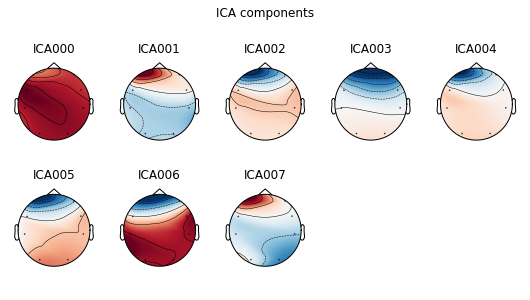

[<Figure size 540x288 with 10 Axes>]

In [15]:
ica.plot_components()

We will have visual representation of every electrod's area, there red - is dinamic activity and blue is blue activity.

Also we can construct a table to represent our data, but this method can't be applied in our study. Nevertheless, we can build table for example:

Also we can construct a table to represent our data, but this method can't be applied in our study. Nevertheless, we can build table for example:

Firstly we need to make some preparations:
<ul>
    <li>We need to convert epoch data back into sequence data.</li>
    <li>We need to prepare some extra data to form table.</li>
    <li>Also we need to add data into table.</li>
</ul>

In [16]:
def remove_epochs(data_epochs):
    dat = data_epochs.get_data()
    data = np.zeros( (dat.shape[0] * dat.shape[2], 8) )
    n_epoch = len(dat)
    n_in_epoch = dat.shape[2]
    for i in range(n_epoch):
        data[i*n_in_epoch:i*n_in_epoch + n_in_epoch] = dat[i].T
    return data
    
def build_table(data):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/SAMPLE_FREQ)
    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    # Plot the data (using pandas here cause it's easy)
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")
    return df

Now, when preparation is complete, we can actually build table:

,band,val
0,Delta,0.322408
1,Theta,0.365089
2,Alpha,0.294705
3,Beta,0.322294
4,Gamma,0.335692


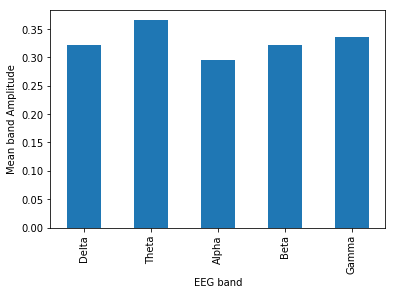

In [17]:
build_table(remove_epochs(ica_data))

<h3>Interpretation</h3>

In interpretation step you should implement analusis of data. In our study we decided to interpret data using vectorization.
Firstly we need to define our eeg bands and channels, also we need to prepare our data:

In [18]:
# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
ch_names = {"fp2":0, "fp1":1, "f4":2, "f3":3, "c4":4, "c3":5, "o2":6, "o1":7}

# Prepare data before vectorization
vector = []
prepared_data = ica_data.get_data()
analysis_data = np.zeros( (prepared_data.shape[0], prepared_data.shape[1]//2, prepared_data.shape[2]) )

Now we can actually apply our vectorization: we would evaluate difference in signal amplitudes with small difference in time using some magic staff like maths. //TODO

In [19]:
i = 0
for sample_epoch in prepared_data:
    analysis_data[i][0] = (sample_epoch[1] - sample_epoch[0]) / (sample_epoch[1] + sample_epoch[0])
    analysis_data[i][1] = (sample_epoch[3] - sample_epoch[2]) / (sample_epoch[3] + sample_epoch[2])
    analysis_data[i][2] = (sample_epoch[5] - sample_epoch[4]) / (sample_epoch[5] + sample_epoch[4])
    analysis_data[i][3] = (sample_epoch[7] - sample_epoch[6]) / (sample_epoch[7] + sample_epoch[6])
    i+=1
    
for epoch in analysis_data:

 # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(epoch.T))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(epoch.T), 1.0/SAMPLE_FREQ)
    eeg_band_fft = dict()

    for band in eeg_bands:
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    vector.append(eeg_band_fft['Alpha'] / eeg_band_fft['Beta'])

vector = np.array(vector)

In analysis often better to work with normalized vector, so let's normalize it:

In [20]:
vector = normalize(vector[:,np.newaxis], axis=0).ravel()

Before next step let's prepare some functions and files, because we have to use several files:

In [21]:
def funct(filename, rows):
    skiprows=10000
    ch_names = {"fp2":1, "fp1":2, "f4":3, "f3":4, "c4":5, "c3":6, "o2":7, "o1":8}
    data = np.loadtxt(filename, comments="%", delimiter=",", converters=converter, skiprows=skiprows, max_rows=rows).T
    data = data[list(ch_names.values())]
    data = filter_data(data, 250, l_freq=2, h_freq=50)
    data = mne.io.RawArray(data, info)
    data_series = create_epochs(data)
    ica = ICA()
    ica.fit(data_series)
    ica_data = ica.apply(data_series)
    eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
    
    ch_names = {"fp2":0, "fp1":1, "f4":2, "f3":3, "c4":4, "c3":5, "o2":6, "o1":7}

    # Prepare data before vectorization
    vector = []
    prepared_data = ica_data.get_data()
    analysis_data = np.zeros( (prepared_data.shape[0], prepared_data.shape[1]//2, prepared_data.shape[2]) )
    
    i = 0
    for sample_epoch in prepared_data:
        analysis_data[i][0] = (sample_epoch[1] - sample_epoch[0]) / (sample_epoch[1] + sample_epoch[0])
        analysis_data[i][1] = (sample_epoch[3] - sample_epoch[2]) / (sample_epoch[3] + sample_epoch[2])
        analysis_data[i][2] = (sample_epoch[5] - sample_epoch[4]) / (sample_epoch[5] + sample_epoch[4])
        analysis_data[i][3] = (sample_epoch[7] - sample_epoch[6]) / (sample_epoch[7] + sample_epoch[6])
        i+=1

    for epoch in analysis_data:

     # Get real amplitudes of FFT (only in postive frequencies)
        fft_vals = np.absolute(np.fft.rfft(epoch.T))

        # Get frequencies for amplitudes in Hz
        fft_freq = np.fft.rfftfreq(len(epoch.T), 1.0/SAMPLE_FREQ)
        eeg_band_fft = dict()

        for band in eeg_bands:
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
            eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

        vector.append(eeg_band_fft['Alpha'] / eeg_band_fft['Beta'])

    vector = np.array(vector)
    return normalize(vector[:,np.newaxis], axis=0).ravel()
    

Now let's use some files to demonstrate analysis: //TODO some trash here

In [22]:
med_vector_1 = funct("samples/meditation_1.txt", 10000)
med_vector_2 = funct("samples/meditation_2.txt", 10000)
cod_vector_1 = funct("samples/coding_1.txt", 10000)
cod_vector_2 = funct("samples/coding_2.txt", 10000)
bas_vector_1 = funct("samples/baseline_1.txt", 10000)
bas_vector_2 = funct("samples/baseline_2.txt", 10000)
print("med-med:")
print(spatial.distance.cosine(med_vector_1, med_vector_2))
print("cod-cod:")
print(spatial.distance.cosine(cod_vector_1, cod_vector_2))
print("bas-bas:")
print(spatial.distance.cosine(bas_vector_1, bas_vector_2))
print("med-cod:")
print(spatial.distance.cosine(med_vector_1, cod_vector_2))
print("med-bas:")
print(spatial.distance.cosine(med_vector_2, bas_vector_1))
print("cod-bas:")
print(spatial.distance.cosine(cod_vector_1, bas_vector_2))

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
40 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 40 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting

C:\Users\paras\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
40 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 40 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting

More long and complete example: //TODO

In [23]:
med_vector_1 = funct("samples/meditation_1.txt", 100000)
med_vector_2 = funct("samples/meditation_2.txt", 100000)
cod_vector_1 = funct("samples/coding_1.txt", 100000)
cod_vector_2 = funct("samples/coding_2.txt", 100000)

print("med-med:")
print(spatial.distance.cosine(med_vector_1, med_vector_2))
print("cod-cod:")
print(spatial.distance.cosine(cod_vector_1, cod_vector_2))

print("med1-cod1:")
print(spatial.distance.cosine(med_vector_1, cod_vector_1))
print("med1-cod2:")
print(spatial.distance.cosine(med_vector_1, cod_vector_2))
print("med2-cod1:")
print(spatial.distance.cosine(med_vector_2, cod_vector_1))
print("med2-cod2:")
print(spatial.distance.cosine(med_vector_2, cod_vector_2))

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Creating RawArray with float64 data, n_channels=8, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   399.996 secs
Ready.
400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 400 events and 176 original time points ...
1 bad epochs dropped
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fit